In [6]:
import torch
import boto3
import glob
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import Client
import warnings
warnings.filterwarnings('ignore')

In [2]:
# method of read training results from s3 bucket to the notebook
def read_s3_tocsv(bucket_name, object_key):
    client = boto3.client('s3')
    csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string), index_col=0)
    return df

In [3]:
def get_results(experiment_list, models):
    df = pd.DataFrame(columns=['Window', 'within_MAE', 'cross_MAE', 'delta_MAE', 'Currency'])
    for curr in experiment_list:
        for model in models:
            file_name = glob.glob(f"ml_res/{curr}*/*{model}.csv")
            data = read_s3_tocsv('crypto-conven-training', f'results/result_{curr}_{model}.csv')
#             print(int(len(data[data.type == 'Within- & Cross-Market'])/2))
            ap = pd.DataFrame({'within_MAE': data[data.type == 'Within-Market']['MAE'].values,
                               'cross_MAE': data[data.type == 'Within- & Cross-Market']['MAE'].values,
                               'Currency': [curr]*int(len(data[data.type == 'Within- & Cross-Market'])),
                               'Window': data['window_index'][:int(len(data[data.type == 'Within- & Cross-Market']))]})
            ap['delta_MAE'] = (ap['within_MAE'] - ap['cross_MAE'])/ap['within_MAE']
            df = pd.concat([df, ap], ignore_index=True)

    df['delta_MAE'] = df['delta_MAE'].astype(float)
    df['Window'] = df['Window'].astype(int)
    return df

In [15]:
experiment_list = ['AUD', 'EUR', 'GBP', 'BTC', 'DOGE', 'ETH']
df = get_results(experiment_list, ['BiLSTMs'])

In [16]:
def hue_regplot(data, x, y, hue, palette=None, markers=['o', 'x', '^', '*', 'v', 's', '>'], **kwargs):
    from matplotlib.cm import get_cmap
    regplots = []
    
    levels = data[hue].unique()
    # if palette is None:
    #     default_colors = ['#F3A712', '#1B263B', ]
    #     palette = {k: default_colors[i] for i, k in enumerate(levels)}
        
    for key, marker in zip(levels, markers):
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                marker=marker,
                label=key,
                **kwargs
            )
        )
        sns.despine()
    
    return regplots

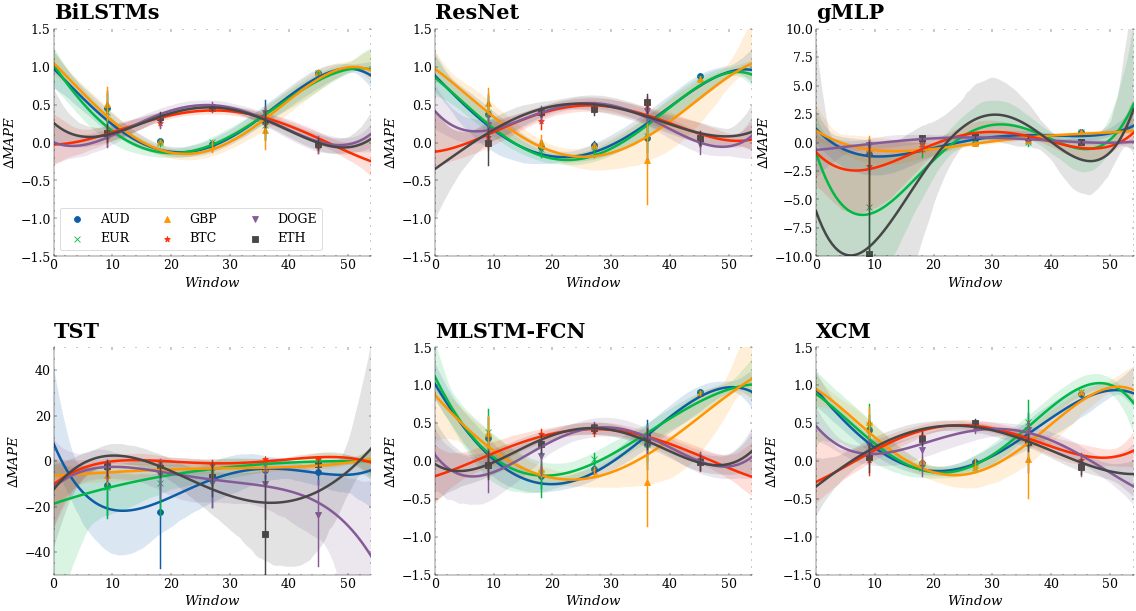

In [19]:
plt.style.use(['nature', 'science', 'no-latex'])
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = False
fig, axis = plt.subplots(2, 3, dpi=60, figsize=(20, 13), linewidth=10)

df = get_results(experiment_list, ['BiLSTMs'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[0, 0],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[0, 0].set_title('BiLSTMs', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[0, 0].tick_params(axis='both', which='major', labelsize=15)
axis[0, 0].set_xlabel(r'${Window}$', size=16)
axis[0, 0].set_ylabel(r'${∆MAPE}$', size=16)
axis[0, 0].set_ylim([-1.5, 1.5])
axis[0, 0].legend(loc='lower left', fontsize=15, frameon=True, ncol=3)

df = get_results(experiment_list, ['ResNet'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[0, 1],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[0, 1].set_title('ResNet', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[0, 1].tick_params(axis='both', which='major', labelsize=15)
axis[0, 1].set_xlabel(r'${Window}$', size=16)
axis[0, 1].set_ylabel(r'${∆MAPE}$', size=16)
axis[0, 1].set_ylim([-1.5, 1.5])

df = get_results(experiment_list, ['gMLP'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[0, 2],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[0, 2].set_title('gMLP', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[0, 2].tick_params(axis='both', which='major', labelsize=15)
axis[0, 2].set_xlabel(r'${Window}$', size=16)
axis[0, 2].set_ylabel(r'${∆MAPE}$', size=16)
axis[0, 2].set_ylim([-10, 10])

df = get_results(experiment_list, ['TST'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[1, 0],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[1, 0].set_title('TST', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[1, 0].tick_params(axis='both', which='major', labelsize=15)
axis[1, 0].set_xlabel(r'${Window}$', size=16)
axis[1, 0].set_ylabel(r'${∆MAPE}$', size=16)
axis[1, 0].set_ylim([-50, 50])

df = get_results(experiment_list, ['MLSTM_FCN'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[1, 1],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[1, 1].set_title('MLSTM-FCN', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[1, 1].tick_params(axis='both', which='major', labelsize=15)
axis[1, 1].set_xlabel(r'${Window}$', size=16)
axis[1, 1].set_ylabel(r'${∆MAPE}$', size=16)
axis[1, 1].set_ylim([-1.5, 1.5])

df = get_results(experiment_list, ['XCM'])
hue_regplot(x='Window', y='delta_MAE', hue='Currency', data=df, ax=axis[1, 2],
            scatter_kws={'s':50}, line_kws={'linewidth': 3}, x_bins=5, order=4)
axis[1, 2].set_title('XCM', loc='left', fontsize=25, fontweight ="bold", pad=12)
axis[1, 2].tick_params(axis='both', which='major', labelsize=15)
axis[1, 2].set_xlabel(r'${Window}$', size=16)
axis[1, 2].set_ylabel(r'${∆MAPE}$', size=16)
axis[1, 2].set_ylim([-1.5, 1.5])

plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.2, hspace=0.4)
plt.savefig('lm_results.svg')
plt.show()